# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

## Библиотеки

In [116]:
import sqlalchemy
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Подключение к БД

In [2]:
# Создаем подключение к базе данных
pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()

In [3]:
# посмотрим, какие таблицы есть в бд
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"
cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

print("Таблицы БД: %s" % tables_data)

Таблицы БД: [('hr_dataset',), ('production_staff',), ('recruiting_costs',), ('salary_grid',)]


In [ ]:
hr_dataset = pd.read_sql('SELECT * FROM hr_dataset', conn)
production_staff = pd.read_sql('SELECT * FROM production_staff', conn)
recruiting_costs = pd.read_sql('SELECT * FROM recruiting_costs', conn)
salary_grid = pd.read_sql('SELECT * FROM salary_grid', conn)

## Руководитель и его работники

In [177]:
# Проверяем, есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.

# Создаю подключение к базе
conn = psycopg2.connect(**pg_connection)
# Создаю объект курсора
cursor = conn.cursor()

# Создаю запрос к базе данных, в которых выбираю имена менеджеров, оценку производительности и их кол-во из таблицы hr_dataset
sql_str = 'SELECT "Manager Name", "Performance Score", COUNT(*) FROM public.hr_dataset GROUP BY "Manager Name", "Performance Score";'
# извлекаю запрос
cursor.execute(sql_str)
# Все данные полученные из запроса присваиваю переменной
newlist = cursor.fetchall()
# Сохранил изменения
conn.commit()
# Закрываем подключение к бд
conn.close()

In [178]:
# Создаю пустой словарь
perf_dict= {}
# Наполняем пустой словарь ключами из имен менеджеров
[perf_dict.update({x[0]:{}}) for x in newlist]
perf_dict

{'Amy Dunn': {},
 'Lynn Daneault': {},
 'Webster Butler': {},
 'David Stanley': {},
 'Simon Roup': {},
 'Brannon Miller': {},
 'Brandon R. LeBlanc': {},
 'Kissy Sullivan': {},
 'Ketsia Liebig': {},
 'Eric Dougall': {},
 'Elijiah Gray': {},
 'Kelley Spirea': {},
 'Janet King': {},
 'Michael Albert': {},
 'Peter Monroe': {},
 'Alex Sweetwater': {},
 'Jennifer Zamora': {},
 'John Smith': {},
 'Board of Directors': {},
 'Debra Houlihan': {},
 'Brian Champaigne': {}}

In [179]:
# Запускаем цикл по данным  полученным из базы данных
for row in newlist:
    name = row[0]
    perf_score = row[1]
    count = row[2]
    perf_dict[name].update({perf_score:count})

Text(0, 0.5, 'Manager Name')

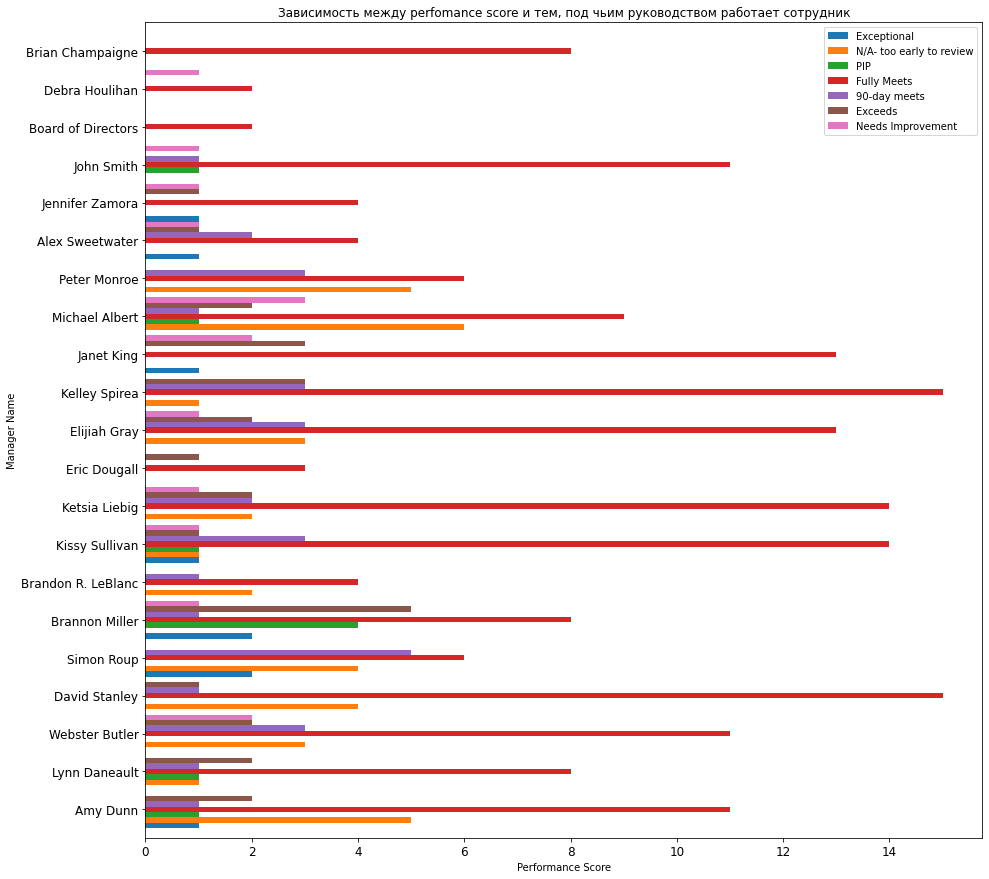

In [180]:
# Преобразую словарь в датафрейм
df_perf_score = pd.DataFrame(perf_dict).T

# Из полученных данных, создаю график
ax = df_perf_score.plot.barh(fontsize=12, figsize=(15,15), width=1, title='Зависимость между perfomance score и тем, под чьим руководством работает сотрудник')
ax.set_xlabel("Performance Score")
ax.set_ylabel("Manager Name")

**Вывод:**

Исходя из графика, мы видем следующее:

Практически у всех менеджеров большинство сотрудников полностью соответствуют требованиям

У Michael Albert показатели сторудников не соответсвует текущим требованиям

Косаемо гипотезы, можно сделать следующий вывод, как видно на графике у Brian Champaigne сотрудники полностью соответсвовали всем требованиям, и на основании его показателей можно утерждать, что есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.

## Семейное положение и время работы

In [181]:
# Создаю подключение к базе
conn = psycopg2.connect(**pg_connection)
# Создаю объект курсора
cursor = conn.cursor()

# Создаю запрос к базе данных
sql_str = 'SELECT "maritalstatusid", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") from public.hr_dataset GROUP BY "maritalstatusid"'
# извлекаю запрос
cursor.execute(sql_str)
# Все данные полученные из запроса присваиваю переменной
newlist = cursor.fetchall()
# Сохранил изменения
conn.commit()
# Закрываем подключение к бд
conn.close()

Text(0, 0.5, 'maritalstatusid')

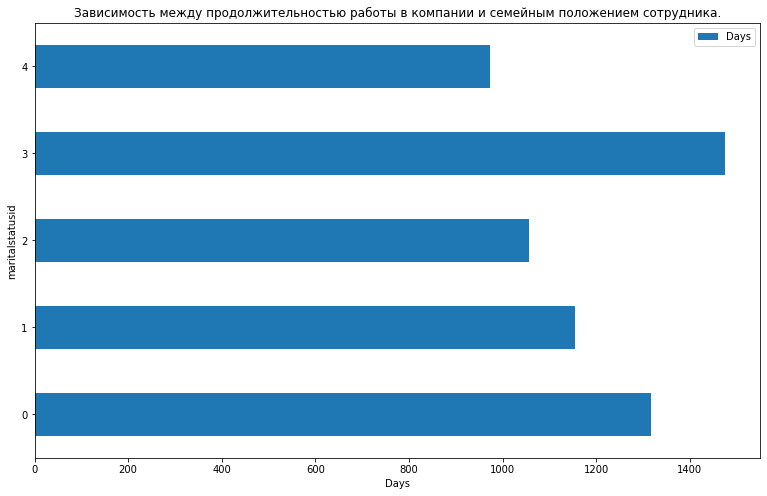

In [182]:
# Создаю датафрейм из полученных в запросе данных
df = pd.DataFrame(newlist, columns=['maritalstatusid', 'Days']).set_index('maritalstatusid')

ax = df.plot.barh(figsize=(13, 8), title='Зависимость между продолжительностью работы в компании и семейным положением сотрудника.')

ax.set_xlabel("Days")
ax.set_ylabel("maritalstatusid")

**Вывод №1:**

Как видно из графика, в большинстве случаев дольше всех работает категория людей, котрые были трижды в браке.

In [183]:
# Создаю подключение к базе
conn = psycopg2.connect(**pg_connection)
# Создаю объект курсора
cursor = conn.cursor()

# Создаю запрос к базе данных
sql_str = 'SELECT "marriedid", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") from public.hr_dataset GROUP BY "marriedid"'
# извлекаю запрос
cursor.execute(sql_str)
# Все данные полученные из запроса присваиваю переменной
newlist = cursor.fetchall()
# Сохранил изменения
conn.commit()
# Закрываем подключение к бд
conn.close()

Text(0, 0.5, 'marriedid')

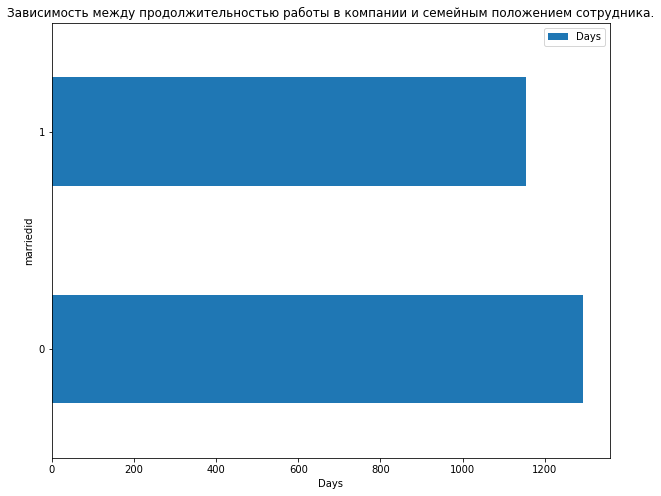

In [184]:
# Создаю датафрейм из полученных в запросе данных
df = pd.DataFrame(newlist, columns=['marriedid', 'Days']).set_index('marriedid')

ax = df.plot.barh(figsize=(10, 8), title='Зависимость между продолжительностью работы в компании и семейным положением сотрудника.')
ax.set_xlabel("Days")
ax.set_ylabel("marriedid")

**Вывод №2:**

Как видно из графика №2, при детальном анализе, на 150 дней проработали больше сотрудники, которые не были в браке. Из 2 показателей графиков, можно сделать вывод, что гипотеза полностью подтвердилась, что есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.

## Время роботы и взраст сотрудника

In [185]:
# Создаю подключение к базе
conn = psycopg2.connect(**pg_connection)
# Создаю объект курсора
cursor = conn.cursor()

# Создаю запрос к базе данных
sql_str = 'select "age", percentile_disc(0.5) within group (order by public.hr_dataset."Days Employed") as days from public.hr_dataset GROUP BY "age" ORDER BY days'
# извлекаю запрос
cursor.execute(sql_str)
# Все данные полученные из запроса присваиваю переменной
newlist = cursor.fetchall()
# Сохранил изменения
conn.commit()
# Закрываем подключение к бд
conn.close()

Text(0, 0.5, 'Age')

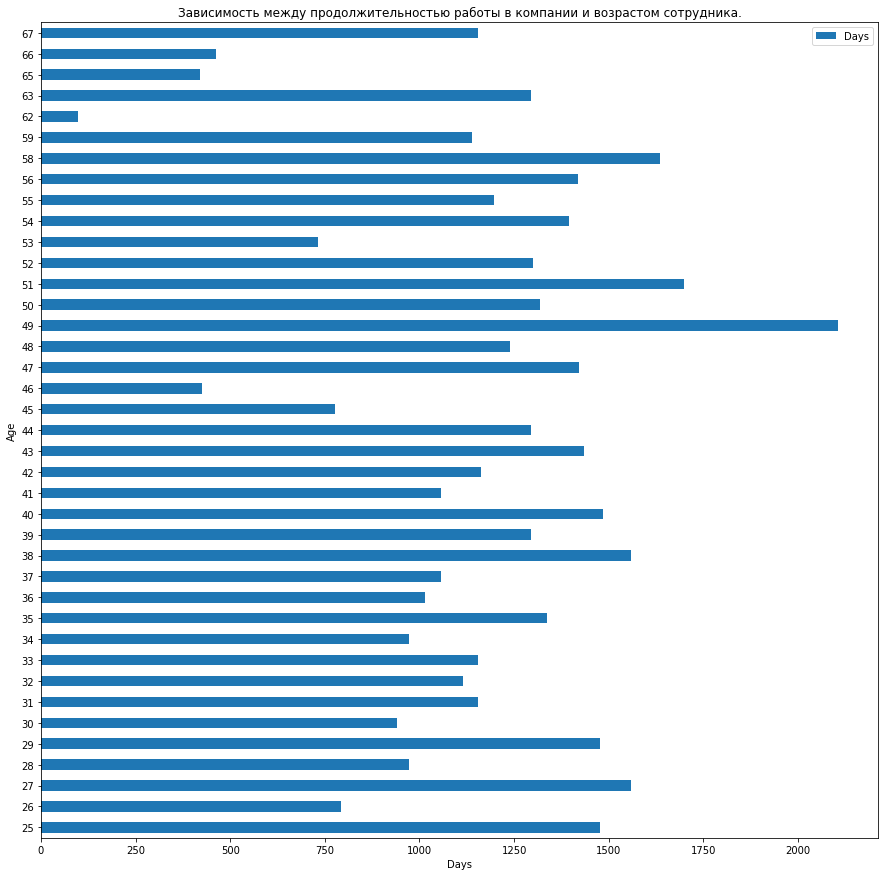

In [186]:
df = pd.DataFrame(newlist, columns=['Age', 'Days']).set_index('Age').sort_index()

ax = df.plot(kind='barh', figsize=(15,15), title='Зависимость между продолжительностью работы в компании и возрастом сотрудника.')

ax.set_xlabel("Days")
ax.set_ylabel("Age")

**Вывод:**

Исходя из графика, дольше всех проработала категория возраста, кому за 49 лет. На мой взгляд, есть зависимость между продолжительностью работы в компании и возрастом сотрудника. Соответсвенно, данная гипотеза так же подтвердилась.

## Зависимость между затратами на поиски работника и результатом поиска

In [228]:
# Создаю подключение к базе
conn = psycopg2.connect(**pg_connection)
# Создаю объект курсора
cursor = conn.cursor()

# Создаю запрос к базе данных
sql_str1 = 'select count("id"), "Employee Source" from hr_dataset group by "Employee Source"'
sql_str2 = 'select "Employment Source", "Total" from recruiting_costs'
# извлекаю запрос
cursor.execute(sql_str1)
newlist1 = cursor.fetchall()

cursor.execute(sql_str2)
newlist2 = cursor.fetchall()
# Сохранил изменения
conn.commit()
# Закрываем подключение к бд
conn.close()

In [238]:
df1 = pd.DataFrame(newlist1, columns=['id', 'Employee Source']).sort_values('Employee Source')
df2 = pd.DataFrame(newlist2, columns=['Employment Sourceid', 'Total']).sort_values('Employment Sourceid')

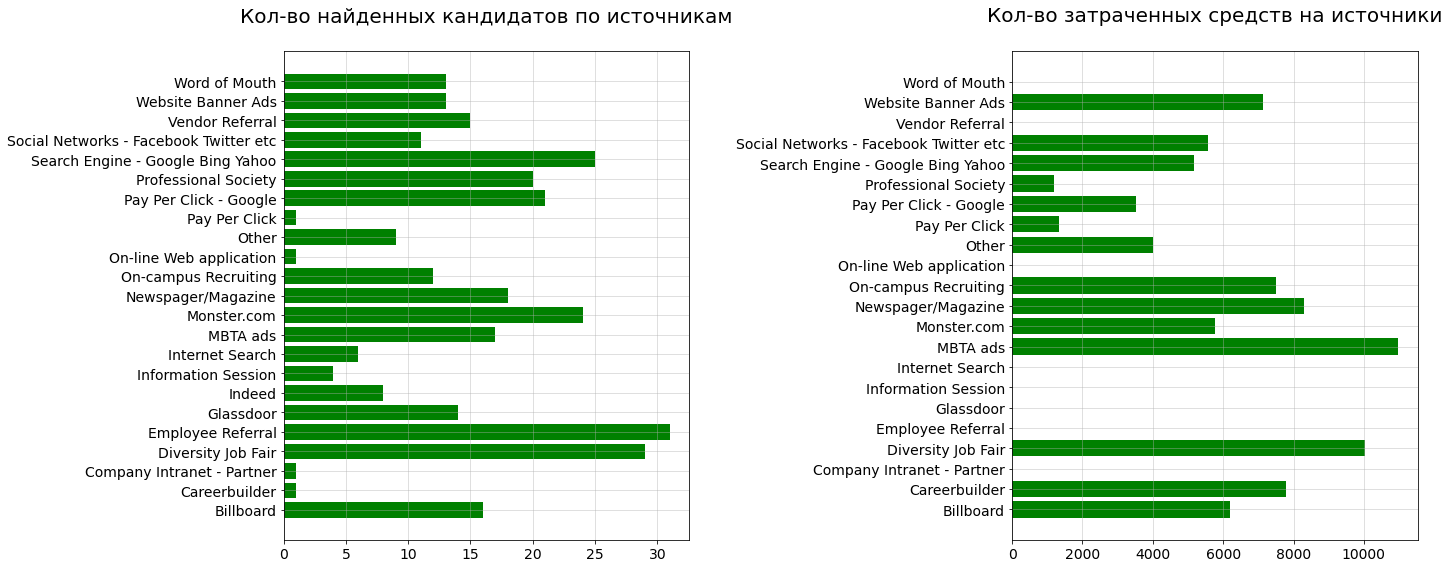

In [241]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].barh(df1['Employee Source'], df1['id'], color = 'green')
ax[0].set_title('Кол-во найденных кандидатов по источникам', pad = 30, fontsize = 20)
ax[0].grid(alpha = 0.5)
ax[0].tick_params(labelsize = 14)

plt.tight_layout (w_pad= 30)

ax[1].barh(df2['Employment Sourceid'], df2['Total'], color = 'green')
ax[1].set_title('Кол-во затраченных средств на источники', pad = 30, fontsize = 20)
ax[1].grid(alpha = 0.5)
ax[1].tick_params(labelsize = 14)

**Вывод:**

Источник ```Employee Referral``` не требующий вложений принес больше всего кандидатов (31), тогда как источник ```MBTA ads``` на который затраченно больше всего денег принес около половины от максимума (17)

Следует изучить графики и подобрать наиболее выгодные источники для сотрудничества, ведь в нашем случаее дорого не значит лучше